# Fine-tuning Pre-trained Model for Perturbation Prediction

In [1]:
import json
import os
import sys
import time
import copy
from pathlib import Path
from typing import Iterable, List, Tuple, Dict, Union, Optional
import warnings

import torch
import numpy as np
np.float = float

import matplotlib
from torch import nn
from torch.nn import functional as F
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
from torch_geometric.loader import DataLoader
from gears import PertData, GEARS
from gears.inference import compute_metrics, deeper_analysis, non_dropout_analysis
from gears.utils import create_cell_graph_dataset_for_prediction

sys.path.insert(0, "../")

import scgpt as scg
from scgpt.model import TransformerGenerator
from scgpt.loss import (
    masked_mse_loss,
    criterion_neg_log_bernoulli,
    masked_relative_error,
)
from scgpt.tokenizer import tokenize_batch, pad_batch, tokenize_and_pad_batch
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.utils import set_seed, map_raw_id_to_vocab_id, compute_perturbation_metrics

matplotlib.rcParams["savefig.transparent"] = False
warnings.filterwarnings("ignore")

set_seed(42)

/home/c22200541/miniconda3/envs/scgpt/lib/python3.11/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/c22200541/miniconda3/envs/scgpt/lib/python3.11/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


In [2]:
print("torch:", torch.__version__)
print("scgpt", scg.__version__)
print("numpy", np.__version__)

torch: 2.3.0+cu121
scgpt 0.2.4
numpy 2.3.4


 ## Training Settings

In [7]:
# settings for data prcocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
pad_value = 0  # for padding values
pert_pad_id = 0
include_zero_gene = "all"
max_seq_len = 1536

# settings for training
MLM = True  # whether to use masked language modeling, currently it is always on.
CLS = False  # celltype classification objective
CCE = False  # Contrastive cell embedding objective
MVC = False  # Masked value prediction for cell embedding
ECS = False  # Elastic cell similarity objective
amp = True
load_model = "../save/scGPT_human"
load_param_prefixs = None

# settings for optimizer
lr = 1e-4  # or 1e-4
batch_size = 32 #64
eval_batch_size = 64
epochs = 5 #15
schedule_interval = 1
early_stop = 10

# settings for the model
embsize = 512  # embedding dimension
d_hid = 512  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 12  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8  # number of heads in nn.MultiheadAttention
n_layers_cls = 3
dropout = 0  # dropout probability
use_fast_transformer = True  # whether to use fast transformer

# logging
log_interval = 100

# dataset and evaluation choices
data_name = "norman"
split = "simulation"
if data_name == "norman":
    perts_to_plot = ["SAMD1+ZBTB1"]
elif data_name == "adamson":
    perts_to_plot = ["KCTD16+ctrl"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
save_dir = Path(f"./save/dev_perturb_{data_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"saving to {save_dir}")

logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")
# log running date and current git commit
logger.info(f"Running on {time.strftime('%Y-%m-%d %H:%M:%S')}")

saving to save/dev_perturb_norman-Dec02-02-02
scGPT - INFO - Running on 2025-12-02 02:02:15


In [5]:
pert_data = PertData("./data")
pert_data.load(data_name=data_name)
pert_data.prepare_split(split=split, seed=1)
pert_data.get_dataloader(batch_size=batch_size, test_batch_size=eval_batch_size)

Found local copy...
Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:9
combo_seen1:52
combo_seen2:18
unseen_single:37
Done!
Creating dataloaders....
Done!


Local copy of pyg dataset is detected. Loading...
Done!
Local copy of split is detected. Loading...
Simulation split test composition:
combo_seen0:0
combo_seen1:0
combo_seen2:0
unseen_single:22
Done!
Creating dataloaders....
Done!


In [12]:
if load_model is not None:
    model_dir = Path(load_model)
    model_config_file = model_dir / "args.json"
    model_file = "./save/dev_perturb_norman-Nov21-22-29/best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    pert_data.adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in pert_data.adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(pert_data.adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    genes = pert_data.adata.var["gene_name"].tolist()

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)
    logger.info(
        f"Resume model from {model_file}, the model args will override the "
        f"config {model_config_file}."
    )
    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]
else:
    genes = pert_data.adata.var["gene_name"].tolist()
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(
    [vocab[gene] if gene in vocab else vocab["<pad>"] for gene in genes], dtype=int
)
n_genes = len(genes)

scGPT - INFO - match 4547/5045 genes in vocabulary of size 60697.
scGPT - INFO - Resume model from ./save/dev_perturb_norman-Nov21-22-29/best_model.pt, the model args will override the config ../save/scGPT_human/args.json.


 # Create and train scGpt

In [13]:
ntokens = len(vocab)  # size of vocabulary
model = TransformerGenerator(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    nlayers_cls=n_layers_cls,
    n_cls=1,
    vocab=vocab,
    dropout=dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    pert_pad_id=pert_pad_id,
    use_fast_transformer=use_fast_transformer,
)
if load_param_prefixs is not None and load_model is not None:
    # only load params that start with the prefix
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if any([k.startswith(prefix) for prefix in load_param_prefixs])
    }

    for k, v in pretrained_dict.items():
        logger.info(f"Loading params {k} with shape {v.shape}")
    
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

elif load_model is not None:
    try:
        model.load_state_dict(torch.load(model_file))
        logger.info(f"Loading all model params from {model_file}")
    except:
        # only load params that are in the model and match the size
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file)
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        for k, v in pretrained_dict.items():
            logger.info(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)
model.to(device)

scGPT - INFO - Loading all model params from ./save/dev_perturb_norman-Nov21-22-29/best_model.pt


TransformerGenerator(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (pert_encoder): Embedding(3, 512, padding_idx=0)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=Tru

In [14]:
def eval_perturb(
    loader: DataLoader, model: TransformerGenerator, device: torch.device
) -> Dict:
    """
    Run model in inference mode using a given data loader
    """

    model.eval()
    model.to(device)
    pert_cat = []
    pred = []
    truth = []
    pred_de = []
    truth_de = []
    results = {}
    logvar = []

    for itr, batch in enumerate(loader):
        batch.to(device)
        pert_cat.extend(batch.pert)

        with torch.no_grad():
            p = model.pred_perturb(
                batch,
                include_zero_gene=include_zero_gene,
                gene_ids=gene_ids,
            )
            t = batch.y
            pred.extend(p.cpu())
            truth.extend(t.cpu())

            # Differentially expressed genes
            for itr, de_idx in enumerate(batch.de_idx):
                pred_de.append(p[itr, de_idx])
                truth_de.append(t[itr, de_idx])

    # all genes
    results["pert_cat"] = np.array(pert_cat)
    pred = torch.stack(pred)
    truth = torch.stack(truth)
    results["pred"] = pred.detach().cpu().numpy().astype(float)
    results["truth"] = truth.detach().cpu().numpy().astype(float)

    pred_de = torch.stack(pred_de)
    truth_de = torch.stack(truth_de)
    results["pred_de"] = pred_de.detach().cpu().numpy().astype(float)
    results["truth_de"] = truth_de.detach().cpu().numpy().astype(float)

    return results

 ## Evaluations

In [15]:
def predict(
    model: TransformerGenerator, pert_list: List[str], pool_size: Optional[int] = None
) -> Dict:
    """
    Predict the gene expression values for the given perturbations.

    Args:
        model (:class:`torch.nn.Module`): The model to use for prediction.
        pert_list (:obj:`List[str]`): The list of perturbations to predict.
        pool_size (:obj:`int`, optional): For each perturbation, use this number
            of cells in the control and predict their perturbation results. Report
            the stats of these predictions. If `None`, use all control cells.
    """
    adata = pert_data.adata
    ctrl_adata = adata[adata.obs["condition"] == "ctrl"]
    if pool_size is None:
        pool_size = len(ctrl_adata.obs)
    gene_list = pert_data.gene_names.values.tolist()
    for pert in pert_list:
        for i in pert:
            if i not in gene_list:
                raise ValueError(
                    "The gene is not in the perturbation graph. Please select from GEARS.gene_list!"
                )

    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        results_pred = {}
        for pert in pert_list:
            cell_graphs = create_cell_graph_dataset_for_prediction(
                pert, ctrl_adata, gene_list, device, num_samples=pool_size
            )
            loader = DataLoader(cell_graphs, batch_size=eval_batch_size, shuffle=False)
            preds = []
            for batch_data in loader:
                pred_gene_values = model.pred_perturb(
                    batch_data, include_zero_gene, gene_ids=gene_ids, amp=amp
                )
                preds.append(pred_gene_values)
            preds = torch.cat(preds, dim=0)
            results_pred["_".join(pert)] = np.mean(preds.detach().cpu().numpy(), axis=0)

    return results_pred



In [16]:
def plot_perturbation(
    model: nn.Module, query: str, save_file: str = None, pool_size: int = None
) -> matplotlib.figure.Figure:
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns

    sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)

    adata = pert_data.adata
    gene2idx = pert_data.node_map
    cond2name = dict(adata.obs[["condition", "condition_name"]].values)
    gene_raw2id = dict(zip(adata.var.index.values, adata.var.gene_name.values))

    de_idx = [
        gene2idx[gene_raw2id[i]]
        for i in adata.uns["top_non_dropout_de_20"][cond2name[query]]
    ]
    genes = [
        gene_raw2id[i] for i in adata.uns["top_non_dropout_de_20"][cond2name[query]]
    ]
    truth = adata[adata.obs.condition == query].X.toarray()[:, de_idx]
    if query.split("+")[1] == "ctrl":
        pred = predict(model, [[query.split("+")[0]]], pool_size=pool_size)
        pred = pred[query.split("+")[0]][de_idx]
    else:
        pred = predict(model, [query.split("+")], pool_size=pool_size)
        pred = pred["_".join(query.split("+"))][de_idx]
    ctrl_means = adata[adata.obs["condition"] == "ctrl"].to_df().mean()[de_idx].values

    pred = pred - ctrl_means
    truth = truth - ctrl_means

    fig, ax = plt.subplots(figsize=[16.5, 4.5])
    plt.title(query)
    plt.boxplot(truth, showfliers=False, medianprops=dict(linewidth=0))

    for i in range(pred.shape[0]):
        _ = plt.scatter(i + 1, pred[i], color="red")

    plt.axhline(0, linestyle="dashed", color="green")

    ax.xaxis.set_ticklabels(genes, rotation=90)

    plt.ylabel("Change in Gene Expression over Control", labelpad=10)
    plt.tick_params(axis="x", which="major", pad=5)
    plt.tick_params(axis="y", which="major", pad=5)
    sns.despine()

    if save_file:
        fig.savefig(save_file, bbox_inches="tight", transparent=False)

    return fig

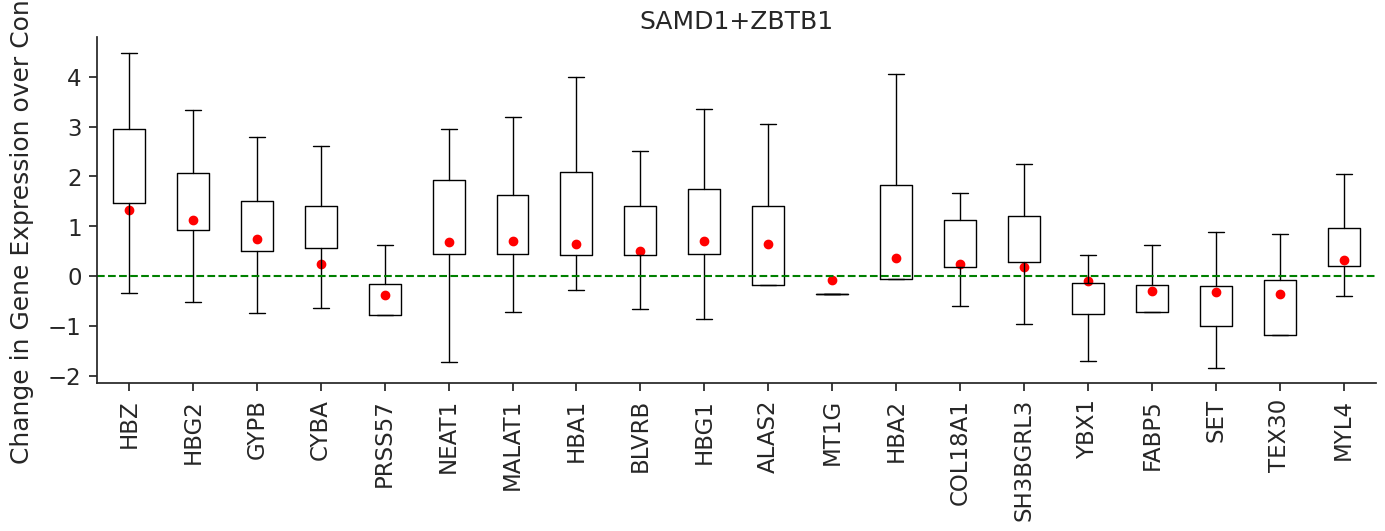

In [18]:
# predict(best_model, [["FEV"], ["FEV", "SAMD11"]])
best_model = copy.deepcopy(model)
for p in perts_to_plot:
    #plot_perturbation(best_model, p, pool_size=1, save_file=f"{save_dir}/{p}.png")
    plot_perturbation(best_model, p, pool_size=300, save_file=f"{save_dir}/{p}.png")

In [19]:
test_loader = pert_data.dataloader["test_loader"]
test_res = eval_perturb(test_loader, best_model, device)
# test_metrics, test_pert_res = compute_metrics(test_res)
test_metrics = compute_perturbation_metrics(
    test_res, pert_data.adata[pert_data.adata.obs["condition"] == "ctrl"]
)
print(test_metrics)

# save the dicts in json
with open(f"{save_dir}/test_metrics.json", "w") as f:
    json.dump(test_metrics, f)
# with open(f"{save_dir}/test_pert_res.json", "w") as f:
#     json.dump(test_pert_res, f)

deeper_res = deeper_analysis(pert_data.adata, test_res)
non_dropout_res = non_dropout_analysis(pert_data.adata, test_res)

metrics = ["pearson_delta", "pearson_delta_de"]
metrics_non_dropout = [
    "pearson_delta_top20_de_non_dropout",
    "pearson_top20_de_non_dropout",
]
subgroup_analysis = {}
for name in pert_data.subgroup["test_subgroup"].keys():
    subgroup_analysis[name] = {}
    for m in metrics:
        subgroup_analysis[name][m] = []

    for m in metrics_non_dropout:
        subgroup_analysis[name][m] = []

for name, pert_list in pert_data.subgroup["test_subgroup"].items():
    for pert in pert_list:
        for m in metrics:
            subgroup_analysis[name][m].append(deeper_res[pert][m])

        for m in metrics_non_dropout:
            subgroup_analysis[name][m].append(non_dropout_res[pert][m])

for name, result in subgroup_analysis.items():
    for m in result.keys():
        mean_value = np.mean(subgroup_analysis[name][m])
        logger.info("test_" + name + "_" + m + ": " + str(mean_value))


{'pearson': np.float64(0.9868226154031776), 'pearson_de': np.float64(0.9302535671171523), 'pearson_delta': np.float64(0.48856153476333275), 'pearson_de_delta': np.float64(0.6944433500735355)}
scGPT - INFO - test_combo_seen0_pearson_delta: 0.44097767732918636
scGPT - INFO - test_combo_seen0_pearson_delta_de: 0.4840338312073864
scGPT - INFO - test_combo_seen0_pearson_delta_top20_de_non_dropout: 0.6593217601446844
scGPT - INFO - test_combo_seen0_pearson_top20_de_non_dropout: 0.8985396012622656
scGPT - INFO - test_combo_seen1_pearson_delta: 0.5632097218528606
scGPT - INFO - test_combo_seen1_pearson_delta_de: 0.6885314655782118
scGPT - INFO - test_combo_seen1_pearson_delta_top20_de_non_dropout: 0.7910299289615075
scGPT - INFO - test_combo_seen1_pearson_top20_de_non_dropout: 0.9157410682803392
scGPT - INFO - test_combo_seen2_pearson_delta: 0.6079769126195741
scGPT - INFO - test_combo_seen2_pearson_delta_de: 0.8132556395249897
scGPT - INFO - test_combo_seen2_pearson_delta_top20_de_non_dropout